In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.6 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have

GBDT: 100%|██████████| 200/200 [00:00<00:00, 2517.12it/s]


GBDT 1%: MAE=0.8109 (0.1s)


GBDT: 100%|██████████| 200/200 [00:00<00:00, 495.01it/s]


GBDT 10%: MAE=0.8138 (0.4s)
1% split epoch 1/10  MAE=0.9482
1% split epoch 2/10  MAE=0.6574
1% split epoch 4/10  MAE=0.9214
1% split epoch 6/10  MAE=0.6382
1% split epoch 8/10  MAE=0.5660
1% split epoch 10/10  MAE=0.5715
TUNED CGCNN 1% split: final MAE=0.5715

10% split epoch 1/40  MAE=0.5594
10% split epoch 8/40  MAE=0.2762
10% split epoch 16/40  MAE=0.2865
10% split epoch 24/40  MAE=0.2317
10% split epoch 32/40  MAE=0.2370
10% split epoch 40/40  MAE=0.2805
TUNED CGCNN 10% split: final MAE=0.2805

   model split      N       MAE
0   GBDT    1%   1328  0.810881
1   GBDT   10%  13275  0.813845
2  CGCNN    1%   1328  0.571458
3  CGCNN   10%  13275  0.280519


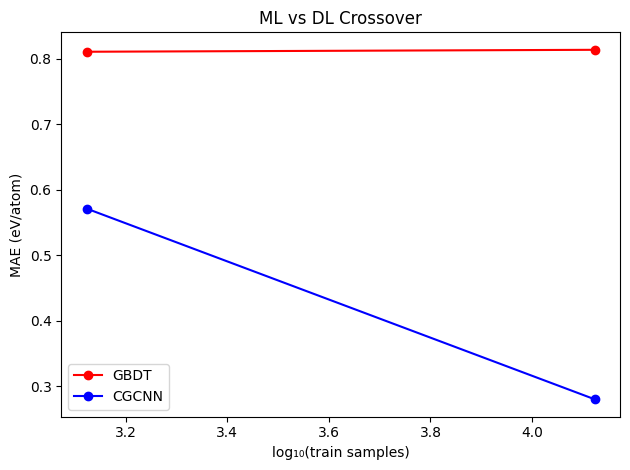

In [2]:
# ────────────────────────────────────────────────────────────────────────────
# Kaggle one-cell notebook – enable Internet + GPU in Settings
# ────────────────────────────────────────────────────────────────────────────

# 1️⃣ Install dependencies
!pip install -q pymatgen>=2024.3 scikit-learn tqdm torch matplotlib

# 2️⃣ All-in-one script
import gzip, json, urllib.request, time
import numpy as np, pandas as pd, torch, torch.nn as nn, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# ── Download & load mp_e_form ───────────────────────────────────────────────
URL = "https://figshare.com/ndownloader/files/17476028"
print("Downloading dataset…")
txt = gzip.decompress(urllib.request.urlopen(URL).read()).decode()
parsed = json.loads(txt)
df0 = pd.DataFrame(parsed["data"], columns=parsed["columns"]) if isinstance(parsed, dict) else pd.DataFrame(parsed)

def to_struct(d):
    try: return Structure.from_dict(d)
    except: return None

df0["structure"] = df0["structure"].apply(to_struct)
df0 = df0.dropna(subset=["structure","e_form"]).reset_index(drop=True)
df0["composition"] = df0["structure"].apply(lambda s: s.composition.reduced_formula)
df_full = df0[["composition","structure","e_form"]]
print("df_full shape:", df_full.shape)

# ── Create 1% & 10% splits ──────────────────────────────────────────────────
df01 = df_full.sample(frac=0.01, random_state=42).reset_index(drop=True)
df10 = df_full.sample(frac=0.10, random_state=42).reset_index(drop=True)
print("Split sizes:", len(df01), "(1%) |", len(df10), "(10%)")

# ── Scratch GBDT baseline ──────────────────────────────────────────────────
def featurize(df):
    X, y = [], []
    for f, e in zip(df["composition"], df["e_form"]):
        comp = Composition(f); dd = comp.get_el_amt_dict(); tot = sum(dd.values())
        avgZ   = sum(Element(el).Z * a           for el,a in dd.items()) / tot
        avgM   = sum(Element(el).atomic_mass * a for el,a in dd.items()) / tot
        n_elem = len(dd)
        X.append([avgZ, avgM, n_elem])
        y.append(e)
    return np.array(X, np.float32), np.array(y, np.float32)

X01, y01 = featurize(df01)
X10, y10 = featurize(df10)

class Stump:
    def fit(self, X, r):
        best = 1e30
        for j in range(X.shape[1]):
            thr = np.median(X[:, j]); mask = X[:, j] < thr
            if mask.all() or (~mask).all(): continue
            l, r_ = r[mask].mean(), r[~mask].mean()
            mse = ((r - np.where(mask, l, r_))**2).mean()
            if mse < best:
                best, self.j, self.thr, self.l, self.r = mse, j, thr, l, r_

    def predict(self, X):
        return np.where(X[:, self.j] < self.thr, self.l, self.r)

class GBDT:
    def __init__(self, n=200, lr=0.1):
        self.n = n
        self.lr = lr
        self.trees = []
    def fit(self, X, y):
        pred = np.zeros_like(y)
        for _ in tqdm(range(self.n), desc="GBDT"):
            r = y - pred
            t = Stump(); t.fit(X, r)
            self.trees.append(t)
            pred += self.lr * t.predict(X)
    def predict(self, X):
        out = np.zeros(X.shape[0], np.float32)
        for t in self.trees:
            out += self.lr * t.predict(X)
        return out

def run_gbdt(X, y, tag):
    t0 = time.time()
    m = GBDT(); m.fit(X, y)
    mae = mean_absolute_error(y, m.predict(X))
    print(f"GBDT {tag}: MAE={mae:.4f} ({time.time()-t0:.1f}s)")
    return mae

mae_gbr01 = run_gbdt(X01, y01, "1%")
mae_gbr10 = run_gbdt(X10, y10, "10%")

# ── Graph conversion utility ───────────────────────────────────────────────
def struct_to_graph(s, cutoff=5.0):
    zs, edges = [site.specie.Z for site in s], []
    for i, site in enumerate(s):
        for nb in s.get_neighbors(site, cutoff):
            nbr = nb.site if hasattr(nb, "site") else nb[0] if isinstance(nb, (list,tuple)) else nb
            try: j = s.sites.index(nbr)
            except: continue
            edges.append((i, j))
    if not edges: edges = [(i, i) for i in range(len(s))]
    ei = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x  = torch.tensor(zs, dtype=torch.long)
    return x.to(device), ei.to(device)

class GraphConv(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.lin = nn.Linear(d, d, bias=False)
    def forward(self, x, ei):
        src, dst = ei; msg = self.lin(x[src])
        out = torch.zeros_like(x, dtype=torch.float)
        out.index_add_(0, dst, msg)
        return torch.nn.functional.silu(out)

# ── Tuned CGCNN-Lite ───────────────────────────────────────────────────────
class CGCNN_Lite_Tuned(nn.Module):
    def __init__(self, emb_dim=256):
        super().__init__()
        self.emb  = nn.Embedding(100, emb_dim)
        self.gc1  = GraphConv(emb_dim)
        self.gc2  = GraphConv(emb_dim)
        self.head = nn.Sequential(
            nn.Linear(emb_dim, emb_dim//2), nn.SiLU(),
            nn.Linear(emb_dim//2, emb_dim//4), nn.SiLU(),
            nn.Linear(emb_dim//4, 1)
        )
    def forward(self, x, ei):
        h = self.gc1(self.emb(x), ei)
        h = self.gc2(h, ei)
        return self.head(h.mean(dim=0)).squeeze()

def train_cgcnn(df, tag, epochs, lr):
    data = [(*struct_to_graph(s), torch.tensor(e, device=device)) for s,e in zip(df["structure"], df["e_form"])]
    model = CGCNN_Lite_Tuned().to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()
    for ep in range(1, epochs+1):
        tot = 0.0
        for x,ei,y in data:
            opt.zero_grad()
            loss = loss_fn(model(x, ei), y)
            loss.backward()
            opt.step()
            tot += loss.item()
        if ep==1 or ep% (epochs//5)==0:
            print(f"{tag} epoch {ep}/{epochs}  MAE={tot/len(data):.4f}")
    mae = tot/len(data)
    print(f"TUNED CGCNN {tag}: final MAE={mae:.4f}\n")
    return mae

mae_cg01 = train_cgcnn(df01, "1% split",  epochs=10, lr=1e-3)
mae_cg10 = train_cgcnn(df10, "10% split", epochs=40, lr=5e-4)

# ── Plot ML vs DL crossover ────────────────────────────────────────────────
results = pd.DataFrame({
    "model": ["GBDT","GBDT","CGCNN","CGCNN"],
    "split": ["1%","10%","1%","10%"],
    "N":     [len(df01), len(df10)]*2,
    "MAE":   [mae_gbr01, mae_gbr10, mae_cg01, mae_cg10]
})
print(results)

plt.plot(np.log10(results["N"][:2]), results["MAE"][:2], "o-r", label="GBDT")
plt.plot(np.log10(results["N"][2:]), results["MAE"][2:], "o-b", label="CGCNN")
plt.xlabel("log₁₀(train samples)"); plt.ylabel("MAE (eV/atom)")
plt.title("ML vs DL Crossover"); plt.legend(); plt.tight_layout()
plt.show()
# ────────────────────────────────────────────────────────────────────────────
